<a href="https://colab.research.google.com/github/ykenkou001/diveintocode-ml/blob/master/Sprint19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle

In [2]:
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import LeakyReLU, BatchNormalization, Activation, Dropout
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
mkdir .kaggle

In [0]:
ls -a

./  ../  .config/  drive/  .kaggle/  sample_data/


In [0]:
# https://www.kaggle.com/　へアクセスし、ログイン後に右上のプロフィール画像をクリック、さらに"My Account"をクリックする
# このサイトの「API」項目にある"Create New API Token"をクリックすると、kaggle.jsonファイルが自動的にダウンロードされる
# ローカルで、kaggle.json（ダウンロードフォルダにあるはず）をエディターで開く。
# このセルの以下のコードにある token = {'username':'***','key':'***'} における「***」部分を、
# ダウンロードしたkaggle.jsonを参照して書き換え、このセルを実行する

import json

token = {'username':'ykenkou001','key':'a6ed2f37d12c119c883b39e22183dadc'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [0]:
# simpsonデータセットのAPIcommandを叩いてデータセットをダウンロードする
# APIcommandはこちらのサイトに。https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

!kaggle competitions download -c tgs-salt-identification-challenge

depths.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
mkdir test

In [0]:
mkdir train

In [0]:
!unzip /content/test.zip -d test

Archive:  /content/test.zip
   creating: test/images/
  inflating: test/images/8cf16aa0f5.png  
  inflating: test/images/23012be6b7.png  
  inflating: test/images/9e46a3352e.png  
  inflating: test/images/8016056c46.png  
  inflating: test/images/a490a68472.png  
  inflating: test/images/cf19041b8e.png  
  inflating: test/images/a5c02f60cd.png  
  inflating: test/images/631cec82b9.png  
  inflating: test/images/bffa15aaa5.png  
  inflating: test/images/31e17c9459.png  
  inflating: test/images/b695427db8.png  
  inflating: test/images/57b062d234.png  
  inflating: test/images/1705ade299.png  
  inflating: test/images/f1a3d6352e.png  
  inflating: test/images/99e331e803.png  
  inflating: test/images/d343f6974e.png  
  inflating: test/images/068f7a5267.png  
  inflating: test/images/d4c235a41e.png  
  inflating: test/images/bf56f7dd40.png  
  inflating: test/images/6b8b1e7ad6.png  
  inflating: test/images/c268afb4a1.png  
  inflating: test/images/63ed0faeb8.png  
  inflating: test/imag

In [0]:
# train用のデータセットを解凍

!unzip /content/train.zip -d train

In [0]:
#data.py
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    イメージとマスクを同時に生成できます。image_datagenとmask_datagenに同じシードを使用して、
    ジェネレーターの結果を視覚化する場合にイメージとマスクの変換が同じであることを確認します。
    save_to_dir= "your path"を設定します。
    '''
    #インスタンス化
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    #ディレクトリから画像を読み込み、データを生成するジェネレーターを元画像用、
    #mask用にそれぞれ作成する。
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    #image,mask画像をそれぞれ取り出し、データのサイズを調整する。
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 4000,target_size = (256,256),flag_multi_class = False,as_gray = True):
    #testdataのファイルを読み込めるようにし、resize, reshapeする。
    test_image_path_list = glob.glob(test_path+"/*")
    for i in range(num_image):
      #画像サイズの読み込み
        img = io.imread(test_image_path_list[i], as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #莫大な量の戻り値を小分けにして返す
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [0]:
#model.py
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    
    return model

**コードリーディング**

*   kerasで書かれており、入力画像サイズは256×256、ゼロパディングで入力画像サイズと出力サイズは同じ。  
* 活性化関数はreluで重み初期化方法はHe_normal。  
*  U-netの階層は４。  
*  U-Netのencoder部分ではサイズ3×3のカーネルで2つの畳み込み層があり、その後のPooling層ではMaxPoolingしてpool_size(2, 2)なので水平、垂直方向の次元でサイズが半分になる。
*encoderの最後の部分では過学習を防止するためdropout技法を使用、その後、Pooling層があり、MaxPoolingして各次元数を半分にしている。
*  階層4～0までのフィルター枚数の変化は64→128→256→512。
*　U-Netの底の階層では、データのshapeが16×16でフィルター数1024のカーネルサイズ3×3の畳み込み層が2つあり、その後過学習を防ぐためdropout技法を使用している。
*decoder部分に入り、各次元のshapeを倍に（upsampling）し、その後1つの畳み込み層があり、encoderの4層目とdecoderの4層目を結合し（Contracting path）し、2つの畳み込み層を通している。同じ作業を最上層まで繰り返している。
*出力層では活性化関数sofomaxを使い出力している。



In [0]:
from keras.models import Model
from keras.layers import Input, Dense

In [0]:
#main.py
# from model import *
# from data import *

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'/content/drive/My Drive/U-net/train','images','masks',data_gen_args,save_to_dir ='/content/drive/My Drive/U-net/create_pic' )

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=False)
model.fit_generator(myGene,steps_per_epoch=300,epochs=5,callbacks=[model_checkpoint])

testGene = testGenerator("/content/drive/My Drive/U-net/test/images")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("/content/drive/My Drive/U-net/test/predict_file",results)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
_________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/5
Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
300/300 [==============================] - 147s 489ms/step - loss: 0.6123 - acc: 0.7378

Epoch 00001: saving model to unet_membrane.hdf5
Epoch 2/5
300/300 [==============================] - 136s 454ms/step - loss: 0.5791 - acc: 0.7460

Epoch 00002: saving model to unet_membrane.hdf5
Epoch 3/5
300/300 [==============================] - 136s 455ms/step - loss: 0.5416 - acc: 0.7630

Epoch 00003: saving model to unet_membrane.hdf5
Epoch 4/5
300/300 [==============================] - 147s 491ms/step - loss: 0.5229 - acc: 0.7560

Epoch 00004: saving model to unet_membrane.hdf5
Epoch 5/5
300/300 [==============================] - 1069s 4s/step - loss: 0.5297 - acc: 0.7430

Epoch 00005: saving model to unet_membrane.hdf5
30/30 [==============================] - 17s 580ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: /content/drive/My Drive/U-net/test/predict_file/0_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: /content/drive/My Drive/U-net/test/predict_file/1_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: /content/drive/My Drive/U-net/test/predict_file/2_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: /content/drive/My Drive/U-net/test/predict_file/3_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: /content/drive/My Drive/U-net/test/predict_file/4_predict.png is a low contrast image
  warn('%s is a

テスト画像


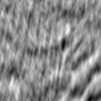

In [0]:
print("テスト画像")
display_png(Image('/content/drive/My Drive/U-net/test/images/0005bb9630.png'))

出力結果


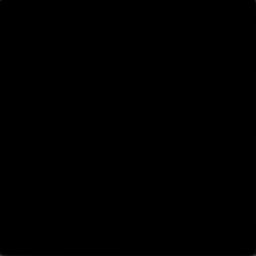

In [7]:
from IPython.display import Image,display_png

print("出力結果")
display_png(Image('/content/drive/My Drive/U-net/test/predict_file/0_predict.png'))